Ejemplo de muestreo MCMC para ajustar datos a un modelo lineal

In [1]:
import matplotlib.pyplot as plt
import scipy.stats as st
import matplotlib as mpl
import seaborn as sb
import pandas as pd
import numpy as np


from matplotlib import animation, rc
from IPython.display import HTML
%matplotlib inline
sb.set()

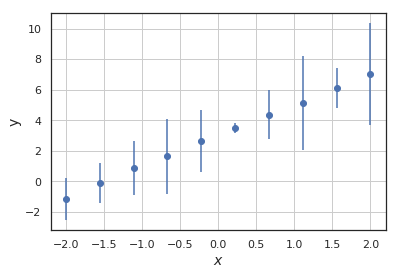

In [2]:
# Aquí se genera el conjunto de datos sinteticos, con dispersión y barras de error.

r     = np.linspace(-2, 2 , 10)  

m     = 2
b     = 3

np.random.seed(100)

dispersion = np.random.normal(-0.0, .1,  size=len(r))
function = m*r + b + dispersion
error = np.random.normal(-0.0, 3,  size=len(r))

sb.set_style("white", {'axes.grid': True})
plt.errorbar(r, function , error, fmt='o')
plt.ylabel('y',fontsize=14)
plt.xlabel('$x$',  fontsize=14)
#plt.plot(r, theory(r, m=1.5, b=3.), 'r-')
#plt.plot(r, theory(r, m=2.5, b=2.75), 'g--')
#plt.plot(r, theory(r, m=2., b=3.), 'r--')
#plt.plot(r, theory(r, m=4., b=0.), 'k--')
plt.savefig("DatosSinteticos.jpg")
plt.show()

In [3]:
df = pd.DataFrame({'x':r, 'f':function, 'error':error})
df.head()

,error,f,x
0,-1.374081,-1.174977,-2.000000
1,1.305490,-0.076843,-1.555556
2,-1.750785,0.893081,-1.111111
3,2.450541,1.641423,-0.666667
4,2.018162,2.653688,-0.222222


In [4]:
s= df['error']**2
covariance = pd.DataFrame(np.diag(s),index=s.index,columns=s.index)

In [5]:
# Define el modelo teórico.

def theory(x, m=2, b=3): 
    return m*x + b

In [6]:
# Se define el loglikelihood para valores particulares de lo parámetros.

def loglike(m=2, b=3):
   #m = params[0]
    
    delta = theory(df['x'], m, b) - df['f']
    chisquare = np.dot(delta,np.dot(np.linalg.inv(covariance),delta))
    
    return -chisquare/2.

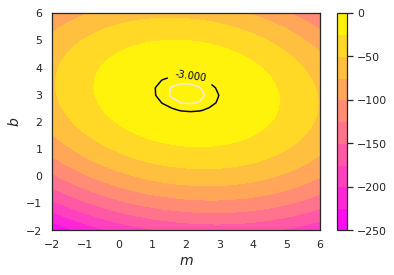

In [7]:
# Se examina el modelo.

from matplotlib import ticker, cm

x = np.linspace(-2, 6, 30)
y = np.linspace(-2, 6, 30)

grid = [map(lambda p: loglike(p, b=i), x) for i in y]
fig, ax = plt.subplots()
gs = ax.contourf(x, y, grid, 10, cmap='spring')
cbar = fig.colorbar(gs)

CS = ax.contour(x, y, grid, np.arange(-3., 3, 2))
ax.clabel(CS, inline=10, fontsize=10)

plt.ylabel('$b$',fontsize=14)
plt.xlabel('$m$',  fontsize=14)
plt.savefig("GraficaContornos.jpg")
plt.show()

In [8]:
def loglike(params):  
    m    = params[0]
    b = params[1]
    
    
    delta = theory(df['x'], m=m, b=b) -  df['f']
    chisquare = np.dot(delta,np.dot(np.linalg.inv(covariance),delta))
    return -chisquare/2

In [9]:
# Aquí comienza el algoritmo MCMC

def target(lik, prior, theta):
    return lik(theta)

In [10]:
def metropolissampler(niters, lik, prior, theta,  sigma):
    accepted = 0
    samples  = [] 
    likeli   = []
    
    samples.append(theta)
    likeli.append(target(lik, prior, theta))
    
    for i in range(niters):
        theta_p = theta + sigma* np.random.normal(0.,1., len(theta)) 
        likeratio=np.exp(target(lik, prior, theta_p) - \
                            target(lik, prior, theta))        
        rho = np.minimum(1, likeratio)
        
        
        if rho > np.random.uniform():
            theta = theta_p
            accepted += 1
            
            
        samples.append(theta)
        likeli.append(target(lik, prior, theta))
    print 'Aceptance rate', 1.0*accepted/niters
    return samples

In [ ]:
# Aquí se definen los parametros asociados a las caminantes que generaran las cadenas de Markov.
lik    = loglike
sigma  = [[0.06, 0.06], [0.1, 0.1], [0.3, 0.3], [0.3, 0.2]]
theta  = [[2.9, 1.], [0., 3.1], [2.1, 2.1], [2.9, 0.5]] 
niters = 2000
prior  = st.uniform(1)

nchains = 4
cadenas = []

sb.set_style("white", {'axes.grid': True})

for i in range(nchains):
    cadenas.append(metropolissampler(niters, lik, prior, theta[i], sigma[i]))
    plt.plot(zip(*cadenas[i])[0], zip(*cadenas[i])[1], label = "Cadena "+str(i+1))

plt.ylabel('$b$',fontsize=14)
plt.xlabel('$m$',  fontsize=14)
plt.legend()
plt.savefig("MuestreoparaMCMC.jpg")
plt.show()

Aceptance rate 0.895
Aceptance rate 0.8505


In [ ]:
# Aqui se generan las regiones de confianza.
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
   
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])

    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [ ]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

fig, ax_nstd = plt.subplots(figsize=(6, 6))
x = np.array(zip(*cadenas[1])[0])
y= np.array(zip(*cadenas[1])[1])
ax_nstd.scatter(x, y, s=0.5)
confidence_ellipse(x, y, ax_nstd, n_std=1, label=r'$1\sigma$', edgecolor='firebrick')
confidence_ellipse(x, y, ax_nstd, n_std=2, label=r'$2\sigma$', edgecolor='firebrick',linestyle='--')
confidence_ellipse(x, y, ax_nstd, n_std=3, label=r'$3\sigma$', edgecolor='firebrick',linestyle=':')
ax_nstd.legend()

####

print(np.cov(x,y))
dg=pd.DataFrame({'x':x,'y':y})
print(dg.describe())

####


sb.set_style("white", {'axes.grid': True})
plt.ylabel('b',fontsize=14)
plt.xlabel('$m$',  fontsize=14)
plt.scatter(2.040, 3.029,s=25,color='r')
plt.savefig("Elipsesdeconfianza.jpg")

In [ ]:
# Prueba Gelman-Rubin

chains = np.array(cadenas)

mean_chain = []
var_chain  = []

n_chains, n_steps, n_params   = np.shape(chains)
bi = int(n_steps*0.1)

for chain in chains:
    mean_chain.append(np.mean(chain[bi:], axis=0))
    var_chain.append( np.var( chain[bi:], axis=0))
    
M = np.mean(mean_chain, axis=0)
W = np.mean(var_chain,  axis=0)



B = 0
for i in np.arange(n_chains):
    B += (mean_chain[i] - M)**2

B = n_steps/(n_chains - 1)*B
R = (1- 1./n_steps)*W +  B/n_steps

print ('Gelman-Rubin Diagnostic:', np.sqrt(R/W), M, W)

print 'Gelman-Rubin:', 1 - np.sqrt(R/W)